# Causal Machine Learning for Treatment Effect Estimation

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

from sklearn.preprocessing import Normalizer

# get standard models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sources.doubly_robust import doubly_robust
from sources.models.TARNet import TARnetICFR

from significance import *

import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from auxiliary import data_processing, doubly_robust, visualise, visualise_ites, impute_missing_values_knn, run_model, undersample, full_contra_indications_tracker, value_based_contra_indications_tracker, period_decomposition, multicol
from icodes import encoding

# from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')

## 1. Introduction

The purpose of this notebook is to provide and end-to-end description of the treatment effect estimation process. This notebook consists of three parts:

1. **Data processing**: The first part is the data processing part. Here we basically prepare the data for the ML models.
2. **Causal ML Models**: The second part of the notebook consists of a series of causal ML learning models. In particular, we use the causal meta-learning framework. 
3. **Adadptive Model**: The third part of the notebook is also a machine learning model. However, contrary to the models before, this one was developed by the VU team and allows for more control over the estimation proces. 

Please find below an overview of the steps we will go through. Note that the boxes do not correspond one-to-one to sections in the notebook, but the general flow is the same. 

![alt text](images\ModellingOverview.jpg)

## 1.a. Preliminaries \& Design Choices

We first want to get some preliminaries out of the way. In particular, we would like to make some specific **design choices** explicit. Below, we can set the following parameters, thereby modifying specific choices:

- ``EXPOSURE_THRESHOLD``: The treatment is binary. However, how much treatment is provided can be changed with this variable. In essence, it determines the cut-off value. For instance, we can set it to 60 minutes in the case of physical therapy (in mins.). Then, patients with more then 60 minutes of PT will be assigned T=1, those below will be T=0.
- ``PERIOD_MIN``: Minimal time period between baseline measurement and followup measurement. N.B. If this is set too low, the effect may not yet register. Too high and the effect may have faded out. 
- ``PERIOD_MAX``: Maximal time period between baseline measurement and followup measurement. N.B. If this is set too low, effect may not yet register. Too high and the effect may have faded out.  
- ``REMOVE_MULTI_COL``: Whether or not to remove multicollinear columns. 
- ``CORRELATION_THRESHOLD``: Threshold for removing collinear columns. 
- ``UNDERSAMPLE``: Some models perform better when undersampling the minority class. For instance, if there are 1000 cases of patients with PT (T=0) and only 150 with PT (T=1), setting this to ``True`` ensures that 150 patients are sampled from PT (T=0), resulting in 300 observations in total.
- ``IMPUTE``: Whether or not to impute missing *covariate* values.
- ``PROPENSITY``: Whether or not to add a propensity score to the model.
- ``CLEAN_COMPARE``: By default (when this is set to ``False``), the data processing script assigns any observations below ``EXPOSURE_THRESHOLD`` to the control group and  any observation above ``EXPOSURE_THRESHOLD`` to treated. Setting this parameter to ``True`` creates a scenario where *only* observation that did not get any treatment are assigned to the control group. For instance, in the case of PT, we would have a control group of patients getting only 0 mins. of PT and a treated group of patients with, say, more than 60 mins. of PT.
- ``TREATMENT``: Name of the treatment variable.
- ``TARGET``: Name of the target variable.

In [2]:
# set seed
np.random.seed(42)

# set the exposure threshold for binary dichtomization. In the case of minor social activities,involved with or without preferences in last 3 days. 
EXPOSURE_THRESHOLD = 1#3 # SET TO 3

# set the period between observations. We only consider the effects between 120 and 240 days after exposure. 
PERIOD_MIN = 120 #240
PERIOD_MAX = 240 #360

# if we want to move multicollinear columns, set to True
REMOVE_MULTI_COL = False

# set the threshold for multicollinearity drops 
CORRELATION_THRESHOLD = 0.6

# set to True if we want to undersample
UNDERSAMPLE = False

# set to True if we want to impute missing values
IMPUTE = True

PROPENSITY = True

# clean compare (to be used if only > threshold AND treatment = 0)
CLEAN_COMPARE = True


TREATMENT = 'is2g' # (days of Social activities)
OUTCOME = 'sADLSF'  

In [3]:
#df

Having set the desired parameters, we will now read in the data.

In [4]:
file = "data/dutch_LTCF_all.csv"

# read data
df = pd.read_csv(file)
print(f"Treatment before processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

Treatment before processing 9524


In [5]:
# code for date

for i in df.columns:
    print(i)

Unnamed: 0
Clientid
Snapshotid
qrt
qrt2
Clientid_original
ClientDepartmentcode
facility_id_first
facility_id
Facility_country
origin
LOS
sum_total
valid_total
Instrument
iA0
iA2
ia4
Age
sAGE_cat
iA6b
ia8
iB2
iA9
yr_assessed
ia11a
ia11b
ia12a
ia13
ib3a
iB4
ib5a
ib5b
ib5c
ib5cnl
ib5d
ib5e
ib6
ib7
ic1
ic4
ic5
ic2a
ic2b
ic2c
ic2c1nl
ic2c2nl
ic2d
ic3a
ic3b
ic3c
id1
id2
id3a
id3b
id4a
id4b
ie1a
ie1b
ie1c
ie1d
ie1e
ie1f
ie1g
ie1h
ie1i
ie1j
ie1k
ie2a
ie2b
ie2c
ie3a
ie3b
ie3c
ie3d
ie3e
ie3f
if4
if1a
if1b
if1c
if1d
if5a
if5b
if5c
if5d
if5e
if5f
if5g
if6a
if6b
if7a
if7b
if7c
if7d
if8a
if8b
if8c
ig3
ig4
ig5
iG8a2
ig12
ig2a
ig2b
ig2c
ig2d
ig2e
ig2f
ig2g
ig2h
ig2i
ig2j
ig6a
ig6b
ig7a
ig7b
ig8a
ih1
ih2
ih3
ih4
ih5
ii1a
ii1b
ii1c
ii1cc
ii1d
ii1dd
ii1e
ii1f
ii1g
ii1h
ii1i
ii1j
ii1k
ii1l
ii1m
ii1n
ii1o
ii1p
ii1q
ii1r
ii1s
ii1t
ii1w
ij1
ij3
ij4
ij7
ij12
ij2a
ij2b
ij2c
ij2d
ij2e
ij2f
ij2g
ij2h
ij2i
ij2j
ij2k
ij2l
ij2m
ij2mm
ij2n
ij2o
ij2p
ij2q
ij2r
ij2s
ij2t
ij5a
ij5b
ij5c
ij5d
ij5e
ij6a
ij6b
ij6c
ij8a
ij

In [6]:
code = 'in5a'
print(encoding[(code).lower()])

Inpatient acute hospital with overnight stay: # times past 90 days


In [7]:
#df['iA9']
# This iA9  means date 

In [8]:
total_samples=len(df)

In [9]:
print(f'Total number of samples:{total_samples}')

Total number of samples:48142


In [10]:
len(df['Clientid'].unique())

12785

In [11]:
#example how to created new variable is2g.cat from is2g
# new variable is2g.cat will take values 1 (if is2g=1 or 3 or 4) or 0 (if is2g=0 or is2g=2)
df['is2g.cat']=df['is2g'].apply(lambda x: 0 if(x==0 or x==2) else 1 if (x==1 or x==3 or x==4) else None)
# Control
pd.crosstab(df['is2g'],df['is2g.cat'])

is2g.cat,0.0,1.0
is2g,,
0.0,33334,0
1.0,0,615
2.0,3981,0
3.0,0,2740
4.0,0,2803


## Part 2. Data Processing

In this first part, we will carry out the data processsing. In particular, we would like to select the relevant covariates, make a pre-selection based on patient characteristics (e.g. whether or not contra-indications are present), select the relevant period of observation, impute missing *coviariate* values and, lastly, handle any multi-collinearity. 

Next, we define the lists of covariates, clinical indications and contra-indications

In [12]:
# list relevant confounders
confounders = ['ia4',  'ii1c', 'ii1d', 'ii1e', 
                        'ii1f', 'ii1h', 'ii1p',  
                        'ii1n', 'ii1o', 'ii1i', 'ii1w', 'if1d', 'cADL', 'sCPS', 'sPAIN', 'iA2', 'sAGE_cat']

#also convert values to list for ease of processing later on 
#listed_val_based_con = [key for key, value in value_based_confounders.items()]
#confounders = confounders =+ Listed_val_based_confounders
        
# ADD VALUE BASED CLINICAL INDICATIONS, E.G. {'sDRS' : [3,4]}

# list of other relevant variables
relevant_vars = ['iA9', 'Clientid', TREATMENT, OUTCOME]

print(len(confounders)) 


17


In [13]:
for col in confounders:
    df[col]

Please note that you can get the meaning of the icodes by running the ``encoding``-function below. You only need to change the name of the ``code`` variable.

In [14]:
code = 'in5a'
print(encoding[(code).lower()])

Inpatient acute hospital with overnight stay: # times past 90 days


Finally, for some contra-indications we want to exclude based on particular values only. We can do this by running the script below. 

Having processed the contra-indications, we can now select the necessary columns in the data.

In [15]:
df['facility_id_first']

0        42420220.0
1        75750563.0
2        42420220.0
3        42420220.0
4        42420220.0
            ...    
48137           NaN
48138           NaN
48139           NaN
48140           NaN
48141           NaN
Name: facility_id_first, Length: 48142, dtype: float64

In [16]:
# df = df[list(confounders + relevant_vars)]
# print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

In [17]:
df = df[list(confounders + relevant_vars)]
print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

Treatment after selecting covariates 10139


In [18]:
df[list(confounders + relevant_vars)]

,ia4,ii1c,ii1d,ii1e,ii1f,ii1h,ii1p,ii1n,ii1o,ii1i,...,if1d,cADL,sCPS,sPAIN,iA2,sAGE_cat,iA9,Clientid,is2g,sADLSF
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,90,2005-06-13,42,4.0,NaN
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,75,2006-06-09,43,0.0,NaN
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1.0,2.0,95,2006-01-13,82,0.0,5.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1.0,2.0,95,2005-06-06,82,0.0,NaN
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,NaN,NaN,0.0,1.0,80,2005-06-13,83,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48137,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,90,2022-11-10,1825793914,4.0,1.0
48138,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,5.0,1.0,2.0,85,2022-11-10,3998986670,0.0,10.0
48139,NaN,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,1.0,1.0,70,2022-11-10,6135579548,1.0,14.0
48140,NaN,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,75,2022-11-10,8479471735,0.0,0.0


In [19]:
df.head()

,ia4,ii1c,ii1d,ii1e,ii1f,ii1h,ii1p,ii1n,ii1o,ii1i,...,if1d,cADL,sCPS,sPAIN,iA2,sAGE_cat,iA9,Clientid,is2g,sADLSF
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,2.0,90,2005-06-13,42,4.0,NaN
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,1.0,75,2006-06-09,43,0.0,NaN
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1.0,2.0,95,2006-01-13,82,0.0,5.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1.0,2.0,95,2005-06-06,82,0.0,NaN
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,NaN,NaN,0.0,1.0,80,2005-06-13,83,0.0,NaN


### 2.b. Baseline-Followup Selection

Important to note here is that in this particular setup, our goal is to **estimate the outcome value at follow up from the covariates *and* outcome variable at baseline**. 

Below you find a schematic depiction of how we want to process the data. As you can see, there are two timelines:

1. **Timeline 1**: Naturally processes from baseline to follow up over time, without any intervention in the meantme.
2. **Timeline 2**: Same as before, but with the difference that not an intervention has take place at some point in time between baseline and follow up. 

![alt text](TimelineModels.jpg)

Our goal is therefore to, *for each observation*, take the values (**pre-treatment** covariates, outcome on baseline $y_{t}$) of baseline, and the  values at follow up (outcome on follow up $y_{t+1}$) and store it in a convenient manner. Important to note is that as patient may have *several* of these baseline-followup recors where sometimes an intervention may have occured and sometimes not. We decided to do this to, again, safe as much data as possible. 

Let us begin by first counting the number of assesments. We do this, because it is not possible to include patients without followup. 

In [20]:
# get number of assesments
counter = lambda x: len(df[df['Clientid']==x])

# count number of items
df['num_assesments'] = df['Clientid'].apply(counter)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


Let us select only observations with more than 2 assesments. 

In [21]:
# get number of assesments higher than 1
df = df[df['num_assesments']>=2]

print(f'{len(df)} observations remaining.')
print(f"Treatment after selecting on number of assesments {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

44613 observations remaining.
Treatment after selecting on number of assesments 9034


In the code below, we want to process the data a bit further. First, we want to make sure that the date columns (``iA9``) is in the correct format. Then we want to order based on ID and date. Also, we want to drop missing dates (if there are any) and drop any duplicated observations. Lastly, we want to make sure that the outcome is in the right format (i.e. a ``float``).

In [22]:
# convert column to datetime 
df['iA9'] = pd.to_datetime(df['iA9']) 
# sort values by ID and date
df = df.sort_values(by = ['Clientid', 'iA9'])
# drop nans on dates of assesment
df = df[df['iA9'].isna()==False]
# drop duplicated values
df = df.drop_duplicates()
df[OUTCOME] = df[OUTCOME].astype(float)

### 2.c Drop Duplicated Values

Next, because there may be two assesments on the same date, we also want to drop those (regardless of the reason as inspecting that is beyond the scope of this project notebook). 

In [23]:
# Group by 'Clientid' and then apply the duplicate check on 'iA9' within each group
duplicated_indices = df.groupby('Clientid').apply(
    lambda x: x[x['iA9'].duplicated()].index).explode()

# Drop NaN values from the index list if they exist
duplicated_indices = duplicated_indices.dropna()

# Convert the result into a list if it's not empty
if not duplicated_indices.empty:
    duplicated_indices = duplicated_indices.tolist()

    # Drop the duplicates using the list of indices
    df = df.drop(index=duplicated_indices)

### 2.d. Clean Compare
If we want to only compare between those patients that receive either 0 treatment or a treatment above the threshold value, we run this code.

In [24]:
if CLEAN_COMPARE:
    df = df[(df[TREATMENT] <= 0) | (df[TREATMENT] >= EXPOSURE_THRESHOLD)]

### 2.e Period Decomposition

The piece of code (i.e. the function ``period_decomposition``) below is a loop that basically does the following:

1. Create a temporary dataframe ``temp_df``. We do this to make sure that there is an empty entity (i.e. data storage) to which we can append new, cleaned and processed observations.
2. Then, for each patient we do the following:
3. Look at all the observation dates.
4. Select the target outcome at follow up and at baseline.
5. Append each period to the ``temp_df`` *until running out of dates*. 
6. Move to the next patient. 

In [25]:
def period_decomposition(df, target):
    # List to store the rows of the new DataFrame
    rows = []

    # Unique client IDs
    client_ids = df['Clientid'].unique()
    total = len(client_ids)

    for count, client_id in enumerate(client_ids, start=1):
        # Inform the user about the progress
        if count % 1000 == 0 or count == total:
            print(f'{count} of {total} items completed...')

        # Extract rows for the current client
        client_rows = df[df['Clientid'] == client_id].sort_values('iA9')
        client_dates = client_rows['iA9'].tolist()

        for i in range(len(client_dates) - 1):
            baseline_date = client_dates[i]
            followup_date = client_dates[i + 1]

            # Extract the rows for baseline and follow-up
            baseline_row = client_rows[client_rows['iA9'] == baseline_date]
            followup_row = client_rows[client_rows['iA9'] == followup_date]
            

            # Calculate the outcomes
            outcome_t0 = float(baseline_row[target])
            outcome_t1 = float(followup_row[target])

            # Prepare a new row with all necessary information
            new_row = baseline_row.iloc[0].to_dict()
            new_row['OutcomeT0'] = outcome_t0
            new_row['OutcomeT1'] = outcome_t1
            new_row['OutcomeT0Date'] = baseline_date
            new_row['OutcomeT1Date'] = followup_date
            rows.append(new_row)

    # Create a new DataFrame from the list of new rows
    temp_df = pd.DataFrame(rows)
    print("Completed.")
    return temp_df


In [26]:
df = period_decomposition(df, target = OUTCOME)
print(f"Treatment after processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

1000 of 9128 items completed...
2000 of 9128 items completed...
3000 of 9128 items completed...
4000 of 9128 items completed...
5000 of 9128 items completed...
6000 of 9128 items completed...
7000 of 9128 items completed...
8000 of 9128 items completed...
9000 of 9128 items completed...
9128 of 9128 items completed...
Completed.
Treatment after processing 6957


### 2.f Dichotomize Treatment Variable

Because our model can only deal with binary treatments, we need to convert the continuous treatments into binary ones. We will do that using a simple fuctions. Recall that the threshold has been set using the ``EXPOSURE_THRESHOLD`` variable above.

In [27]:
#df[TREATMENT]

In [28]:
binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0

In [29]:
#df[TREATMENT].apply(binary)

In [30]:
df[TREATMENT]=df[TREATMENT].apply(binary)

In [31]:
df['treatment']=df[TREATMENT]

In [32]:
df=df.drop(columns=[TREATMENT])

In [33]:
# binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0
# convert treatment to binary
# df['treatment'] = df[TREATMENT].apply(binary)  
# df = df.drop(columns = [TREATMENT])

In [34]:
#df

In [35]:
# drop rows with missing outcome or treatment 
df = df.dropna(subset = ['OutcomeT0', 'OutcomeT1', 'treatment'])
df.head(3)

,ia4,ii1c,ii1d,ii1e,ii1f,ii1h,ii1p,ii1n,ii1o,ii1i,...,sAGE_cat,iA9,Clientid,sADLSF,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment
3,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85,2005-07-01,195,2.0,2,2.0,2.0,2005-07-01,2006-02-14,0
10,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80,2005-10-05,340,6.0,3,6.0,7.0,2005-10-05,2006-02-22,0
15,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80,2005-09-03,408,7.0,2,7.0,9.0,2005-09-03,2006-01-26,0


In [36]:
#df

### 2.g Select Relevant Period

Because the base data is too crude (the time periods between follow-up and baseline may be too far apart), we want to select a suitable period between observations. In essence, we aim to select a time window which is, on the one hand, determined by the minimum time (``PERIOD_MIN``) between baseline measurement and follow-up measurement and the maximum of that time window (``PERIOD_MAX``).

In [37]:
# get difference between dates
df['date_diff'] = df['OutcomeT1Date'] - df['OutcomeT0Date'] 
df['date_diff'] = df['date_diff'].dt.days 

# select relevant period
df = df[df['date_diff'] <= PERIOD_MAX]
df = df[df['date_diff'] >= PERIOD_MIN]

# df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'iA9', OUTCOME, 'Clientid'])
# examine how many treatment observations are left
len(df[df['treatment']==1])

3685

In [38]:
df.head()

,ia4,ii1c,ii1d,ii1e,ii1f,ii1h,ii1p,ii1n,ii1o,ii1i,...,iA9,Clientid,sADLSF,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment,date_diff
3,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2005-07-01,195,2.0,2,2.0,2.0,2005-07-01,2006-02-14,0,228
10,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2005-10-05,340,6.0,3,6.0,7.0,2005-10-05,2006-02-22,0,140
15,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2005-09-03,408,7.0,2,7.0,9.0,2005-09-03,2006-01-26,0,145
24,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2005-07-05,445,6.0,2,6.0,6.0,2005-07-05,2005-12-13,0,161
25,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2005-07-01,447,12.0,3,12.0,12.0,2005-07-01,2005-12-09,0,161


In [39]:
grps = df[['treatment', 'Clientid']].drop_duplicates()
print(f'Number of patients after processing (total): {len(grps)}')
tr = len(grps[grps['treatment']==1])
ct = len(grps[grps['treatment']==0])
print(f'Number of patients after processing (treatment): {ct}')
print(f'Number of patients after processing (treatment): {tr}')
df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'iA9', OUTCOME, 'Clientid'])

Number of patients after processing (total): 5430
Number of patients after processing (treatment): 3958
Number of patients after processing (treatment): 1472


### 2.h Impute Missing Values

In this part, we impute missing values. We use a standard KNN-imputer. If desired, it is possible to change the number of neighbours. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [40]:
#imputing = IMPUTE
if IMPUTE:
    df = impute_missing_values_knn(df, n_neighbors=5)
else:
    df = df.dropna()
    print(len(df[df['treatment']==1]))

### 2.i Handle Multicollinearity

Here we will handle multi-collinear columns. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [41]:
if REMOVE_MULTI_COL:
    print('2sr')
    df = multicol(df, CORRELATION_THRESHOLD)

### 2.j Handle Empty Columns

In the process, it may be that we end up with columns that contain only $0$ values. We want to drop these columns, as they are not informative.

In [42]:
# drop num_assesment column, not relevant anymore
df = df.drop(columns = ['num_assesments'])
# get a list of coviariate columns
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

# drop columns that only have 0 values
for col in X:
    if len(df[df[col]==0]) == len(df):
        print(f"{col} - {encoding[col.lower()]} dropped." )
        df = df.drop(columns = [col])

### 2.k Store CSV

In the last part of this notebook, we will store that data.

In [43]:
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

In [44]:
# treatment = TREATMENT#'in3eb' # (minutes or days of physical therapy)
# target = #'sADLSF' 

#df = df.drop(columns = 'num_assesments')
df.to_csv(f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv", index = False)

In [45]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(encoding[(covar).lower()])
        except:
            covar_names.append(covar)
            
            

In [46]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(covar)
        except:
            covar_names.append(covar)

In [47]:
covar_names

['ia4',
 'ii1c',
 'ii1d',
 'ii1e',
 'ii1f',
 'ii1h',
 'ii1p',
 'ii1n',
 'ii1o',
 'ii1i',
 'ii1w',
 'if1d',
 'cADL',
 'sCPS',
 'sPAIN',
 'iA2',
 'sAGE_cat',
 'OutcomeT0']

### Note to Teams: Please Start Here

**MAKE SURE THAT THE DATA IS IN THE EXACT FORMAT AS BELOW.**

Checklist:

1. The covariates must come first.
2. Then, there must be the outcome at baseline called ``OutcomeT0``.
3. There must be an outcome at followup called ``OutcomeT1``.
4. You may have a propensity score columns (``ps``), but this is not required. Same for clusters.
5. There must be a treatment column *at the end* called ``treatment``. 

Good luck!

## Part 3. Machine Learning

Having processed the data, we can now move on the the machine learning (ML) part. Recall that we model using the meta-learning paradigm. Below is a schematic depiction of the process.

![alt text](images\ModelGoal.jpg)

As can be seen, for a given patient, we can - *after training* - provide the details of that patient. These details are the outcome at baseline (``OutcomeT0``), the covariates and whether or not we include treatment. This allows us to compute the **individual treatment effect** (ITE), the predicted effect unter treatment minus the predicted effect under control.

However, before we are able to estimate the ITE for a patient, we need to train the model. In meta-learning we always train two models. The first model is trained on the control group and the second model is trained on the treated group. Let us now first state what the ``outcome`` and ``intervention`` variables are.  

![alt text](images\GeneralPlotTrajectoryInterpretation.jpg)

Next, we want to select the models. Here we will use ``RandomForestRegressor()``.

In [48]:
model0 = RandomForestRegressor()
model1 = RandomForestRegressor()

In [49]:
model = model0

In [50]:
# File path for the Excel file
excel_file = f'data/hyperparameters/model_hyperparameters_RandomForest.xlsx'

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Get hyperparameters
    hyperparameters = model.get_params()

    # Convert to DataFrame
    df = pd.DataFrame([hyperparameters])

    # Write each model's hyperparameters to a different sheet
    df.to_excel(writer, sheet_name="RandomForest")

print("Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.")

Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.


Then, we want to retrieve the data. We can use the data from above, but here we will read the file. 

In [51]:
# call your data file here
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"

Afterwards, we can run the model. The only thing to do is to run the ``run_model``-function below. 

In [52]:
machine = "RandomForest"

metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c = run_model(n_bootstraps = 30, file = FILE, model0 = model0, model1 = model1, undersampled = UNDERSAMPLE, include_propensity = PROPENSITY, intervention = TREATMENT, outcome = OUTCOME, machine = "RandomForest", num_iter = 1)

DF lenght after undersampling: 13181
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: -0.01, 95% CI: [-1.94, 1.98]


We can now examine the performance of the model by calling ``metrics``.

In [53]:
metrics

,RandomForest
MAE_C,1.124983
MAE_T,1.001861
MSE_C,3.912825
MSE_T,3.080102
R2_C,0.809949
R2_T,0.777466


In [54]:
confidence_interval(data=ites_test)

(-0.09444624635086096, -0.005080465487934595)


In [55]:
significance(data=ites_test)

T-statistic: -2.183815532521715
P-value: 0.02906367451528711
Result is statistically significant


We can also visualise the model's *factual* predicted performance by calling the ``visualise`` function.

In [56]:
len(y_test_t)

737

            0     1        2
0        6.76   7.0  treated
1    0.231641   0.0  treated
2    3.157333   1.0  treated
3    5.223714   3.0  treated
4       12.87  12.0  treated
..        ...   ...      ...
732      5.91   6.0  treated
733      1.44   3.0  treated
734     0.055   0.0  treated
735   0.47413   0.0  treated
736  0.907877   0.0  treated

[737 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
CHECK!
             0     1        2
0         6.76   7.0  treated
1     0.231641   0.0  treated
2     3.157333   1.0  treated
3     5.223714   3.0  treated
4        12.87  12.0  treated
...        ...   ...      ...
1895  4.063333   3.0  control
1896  0.914667   1.0  control
1897  9.816667   3.0  control
1898  0.218159   0.0  control
1899  1.122667   1.0  control

[2637 rows x 3 columns]


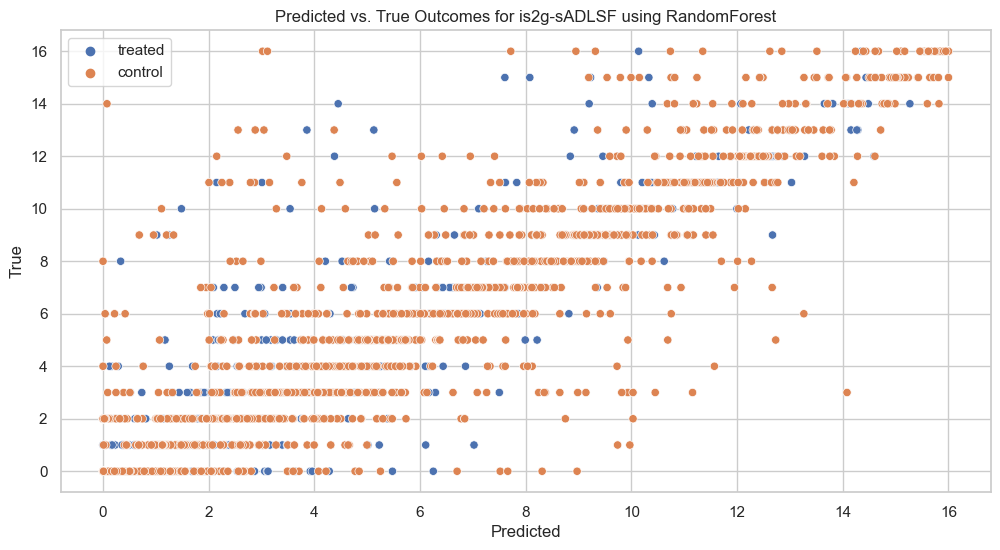

In [57]:
machine = "RandomForest"
visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Also, if we want to visualize the ITES, we can run the following function (``visualise_ites``):

ATE -0.049763355919397796


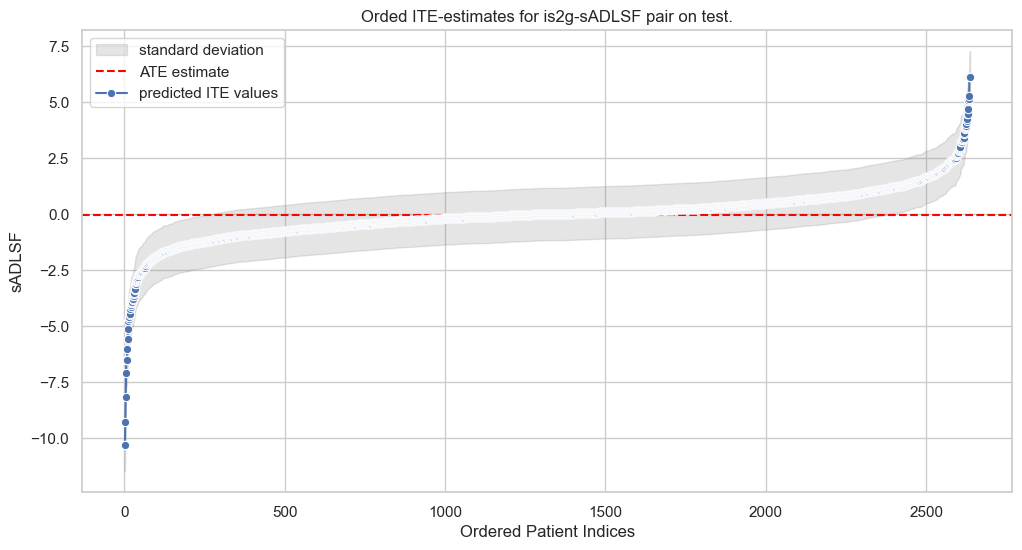

In [58]:
visualise_ites(ites_test, machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE -0.008853620713228857


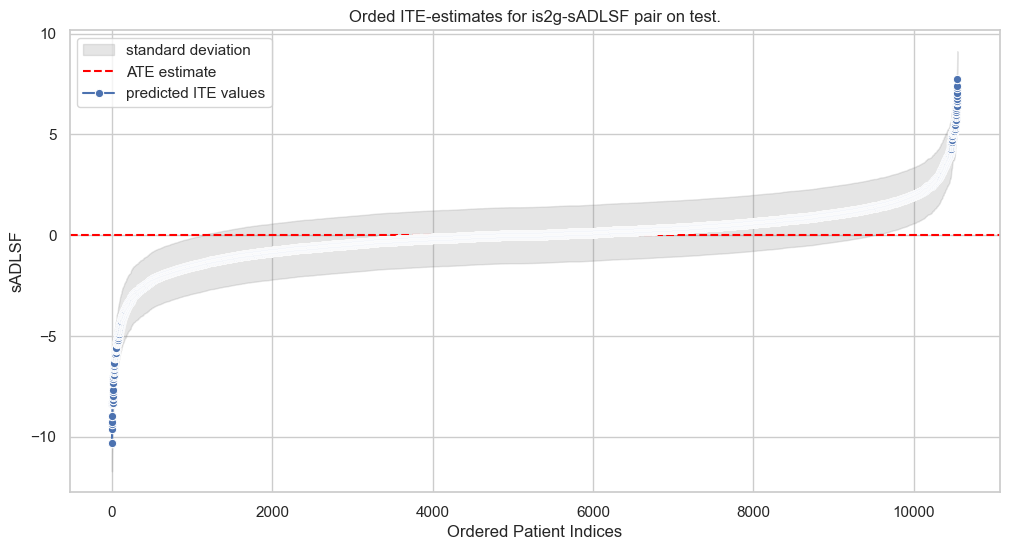

In [59]:
visualise_ites(ites_train, machine = machine, intervention = TREATMENT, target = OUTCOME)

### 3.b Run More Models

These models can be run also. Feel free to remove some of the models, but please run at least:

- ``RandomForestRegressor()``
- ``GradientBoostingRegressor()``
- ``LinearRegression()``

RandomForestRegressor()
DF lenght after undersampling: 13181
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: 0.03, 95% CI: [-1.88, 2.04]
ATE 0.07281150675156953


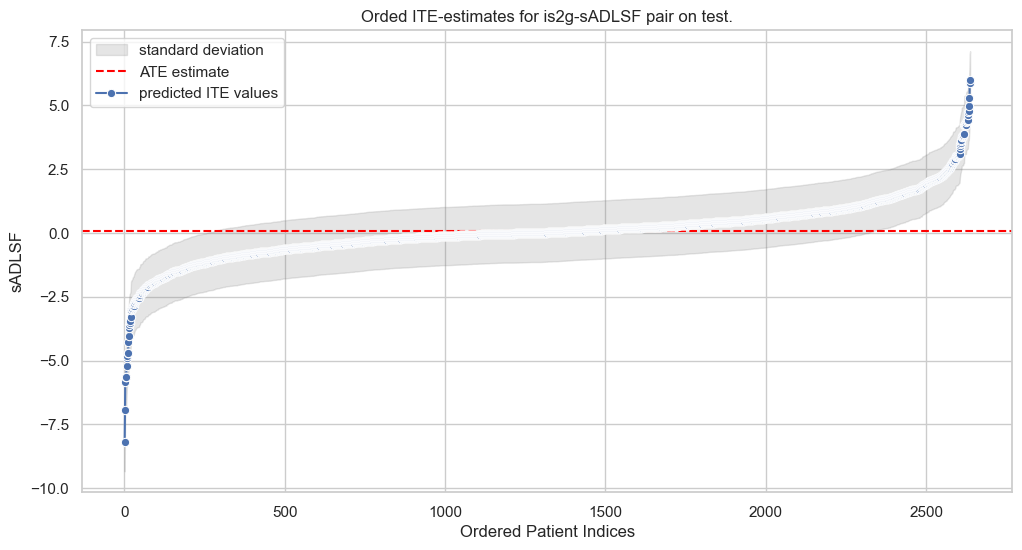

       RandomForestRegressor()
MAE_C                 1.151905
MAE_T                 0.982120
MSE_C                 3.975324
MSE_T                 2.506071
R2_C                  0.800197
R2_T                  0.827239
(0.029285622954045465, 0.1163373905490937)
T-statistic: 3.28019731759928
P-value: 0.001050849177919403
Result is statistically significant
MLPRegressor()
DF lenght after undersampling: 13181
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
ATE: -0.05, 95% CI: [-1.86, 2.06]
ATE 0.010760156874886774


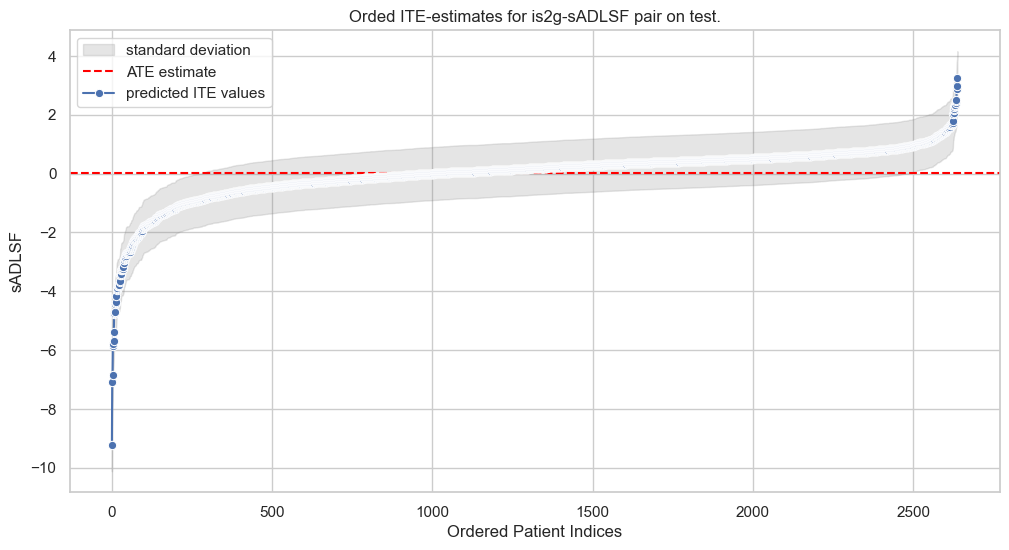

       MLPRegressor()
MAE_C        1.171591
MAE_T        1.021798
MSE_C        3.964763
MSE_T        2.327990
R2_C         0.793114
R2_T         0.854586
(-0.023698101139031362, 0.045218414888804966)
T-statistic: 0.6123120885018036
P-value: 0.5403841065859951
Result is not significant
GradientBoostingRegressor()
DF lenght after undersampling: 13181
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
ATE: -0.06, 95% CI: [-1.98, 1.94]
ATE -0.047919670063422515


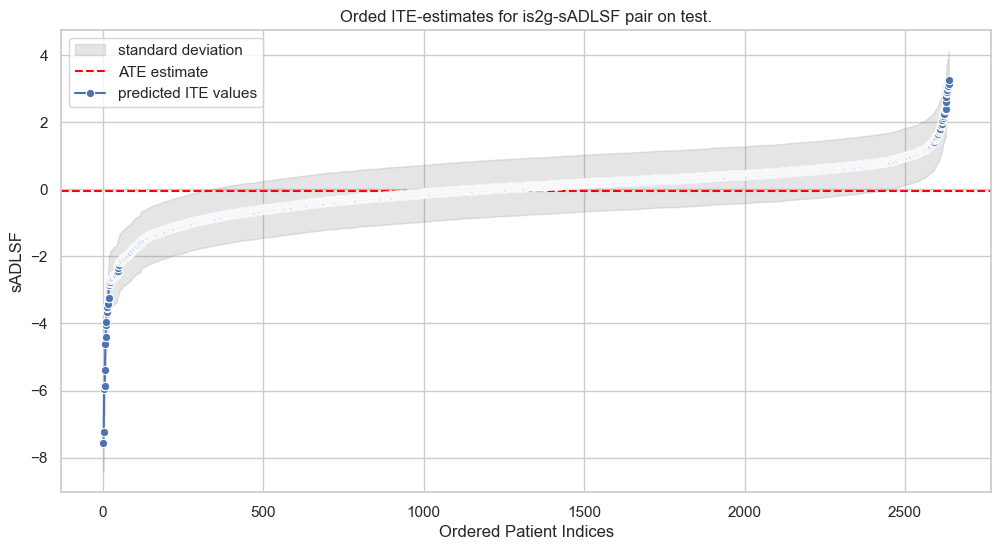

       GradientBoostingRegressor()
MAE_C                     1.191012
MAE_T                     0.977825
MSE_C                     4.611324
MSE_T                     3.055686
R2_C                      0.762375
R2_T                      0.796812
(-0.08025172311613038, -0.01558761701071456)
T-statistic: -2.9062173118460444
P-value: 0.0036887788149754766
Result is statistically significant
DecisionTreeRegressor()
DF lenght after undersampling: 13181
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
ATE: 0.00, 95% CI: [-1.90, 2.02]
ATE -0.018791712611472475


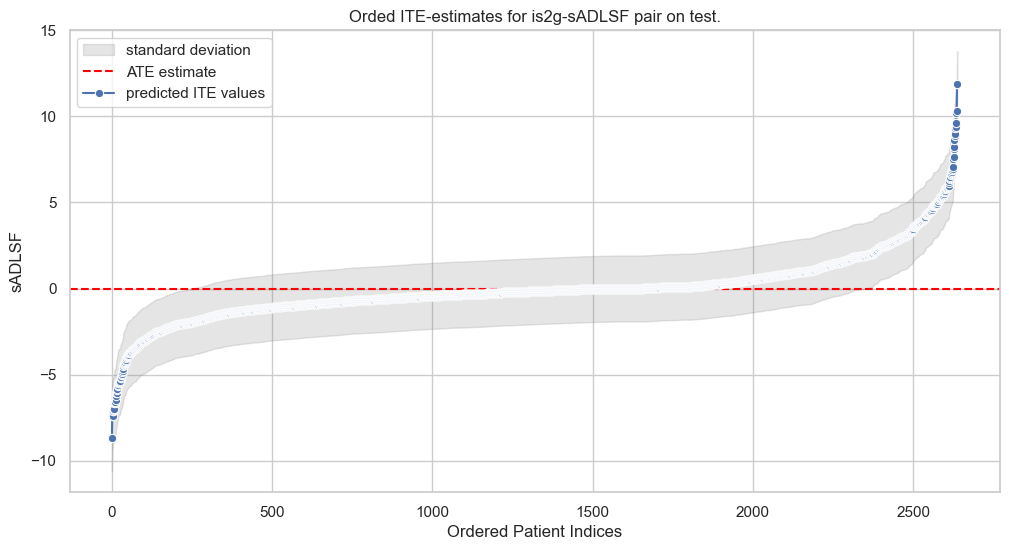

       DecisionTreeRegressor()
MAE_C                 1.162384
MAE_T                 1.230063
MSE_C                 3.851515
MSE_T                 5.218508
R2_C                  0.801936
R2_T                  0.699940
(-0.09201629016382136, 0.05443286494087625)
T-statistic: -0.5032190067495721
P-value: 0.614852347554592
Result is not significant
LinearRegression()
DF lenght after undersampling: 13181
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
ATE: -0.07, 95% CI: [-1.98, 1.94]
ATE -0.09638960414199119


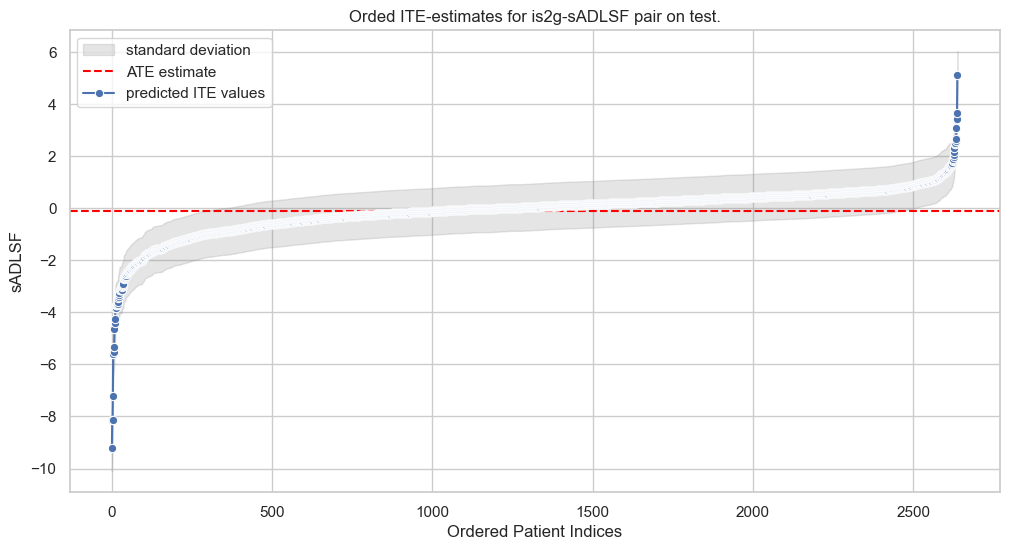

       LinearRegression()
MAE_C            1.170910
MAE_T            0.970458
MSE_C            4.263581
MSE_T            2.629237
R2_C             0.789182
R2_T             0.828635
(-0.13060536790856642, -0.06217384037541595)
T-statistic: -5.523972488062652
P-value: 3.638336813216003e-08
Result is statistically significant
Ridge()
DF lenght after undersampling: 13181
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
ATE: -0.08, 95% CI: [-1.99, 1.93]
ATE -0.12218450606525949


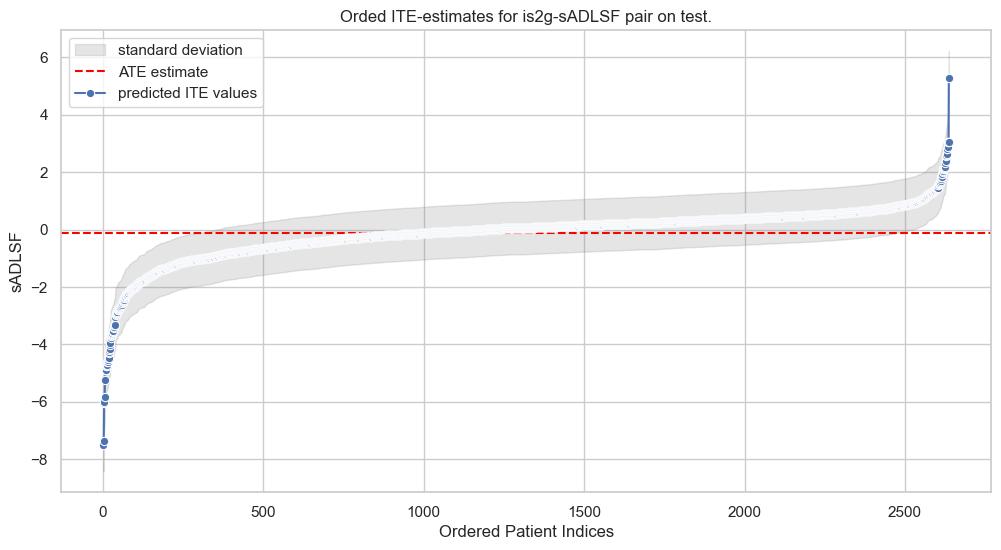

        Ridge()
MAE_C  1.180676
MAE_T  0.951345
MSE_C  3.740743
MSE_T  2.513197
R2_C   0.805259
R2_T   0.833693
(-0.15725649528940727, -0.08711251684111163)
T-statistic: -6.83129889100221
P-value: 1.0410716239798004e-11
Result is statistically significant
Lasso()
DF lenght after undersampling: 13181
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
ATE: -0.16, 95% CI: [-2.09, 1.83]
ATE -0.18929889077298842


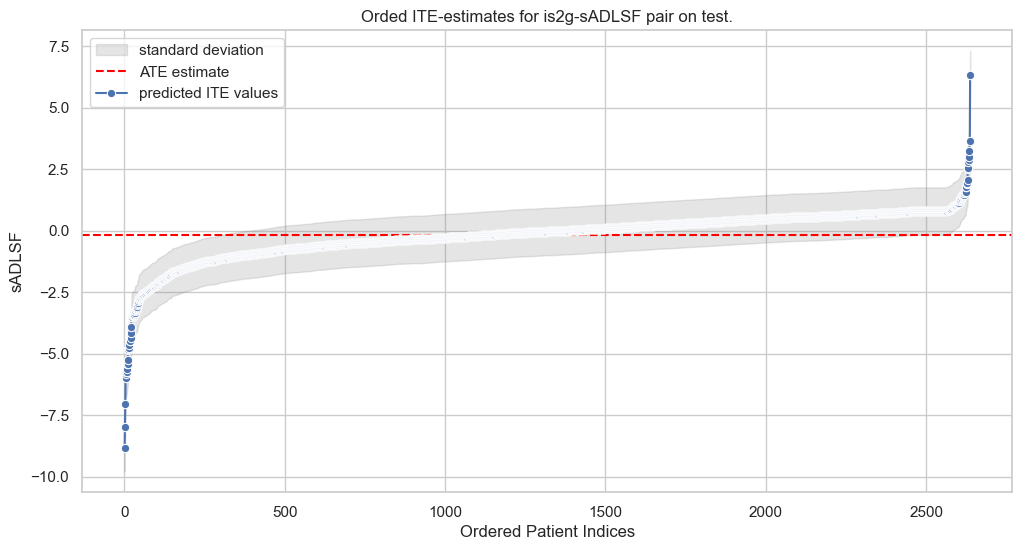

        Lasso()
MAE_C  1.122181
MAE_T  1.039683
MSE_C  3.824001
MSE_T  2.761465
R2_C   0.813375
R2_T   0.771280
(-0.2261085375342894, -0.1524892440116875)
T-statistic: -10.084026269255316
P-value: 1.723450965494949e-23
Result is statistically significant
AdaBoostRegressor()
DF lenght after undersampling: 13181
{'base_estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': None}
ATE: 0.51, 95% CI: [-1.22, 2.70]
ATE 0.4030110367286592


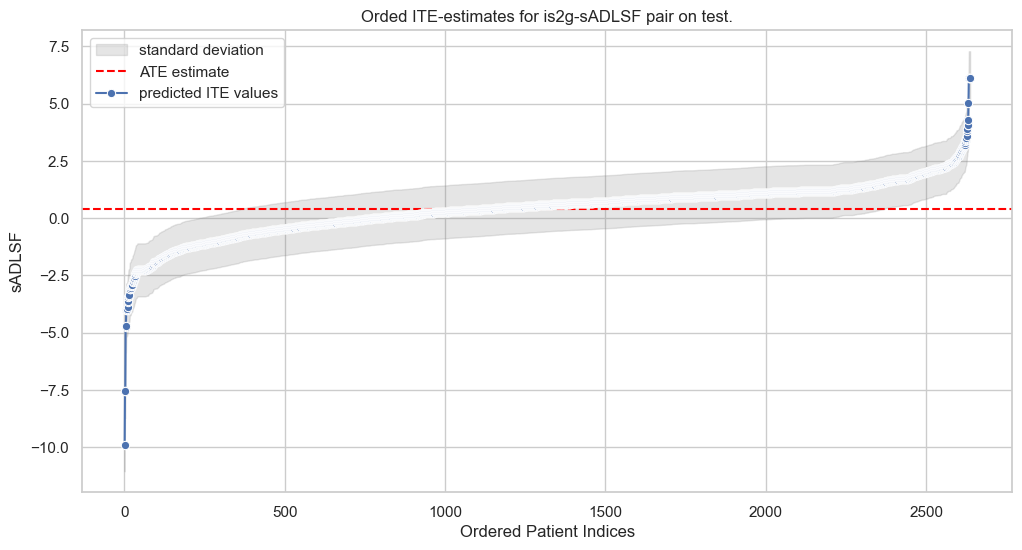

       AdaBoostRegressor()
MAE_C             1.116620
MAE_T             1.525703
MSE_C             3.839977
MSE_T             4.421567
R2_C              0.807301
R2_T              0.649738
(0.3588793234063193, 0.44714275005099907)
T-statistic: 17.906623420544904
P-value: 9.220892575083288e-68
Result is statistically significant
ExtraTreesRegressor()
DF lenght after undersampling: 13181
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: 0.02, 95% CI: [-1.90, 2.02]
ATE 0.025700088506005993


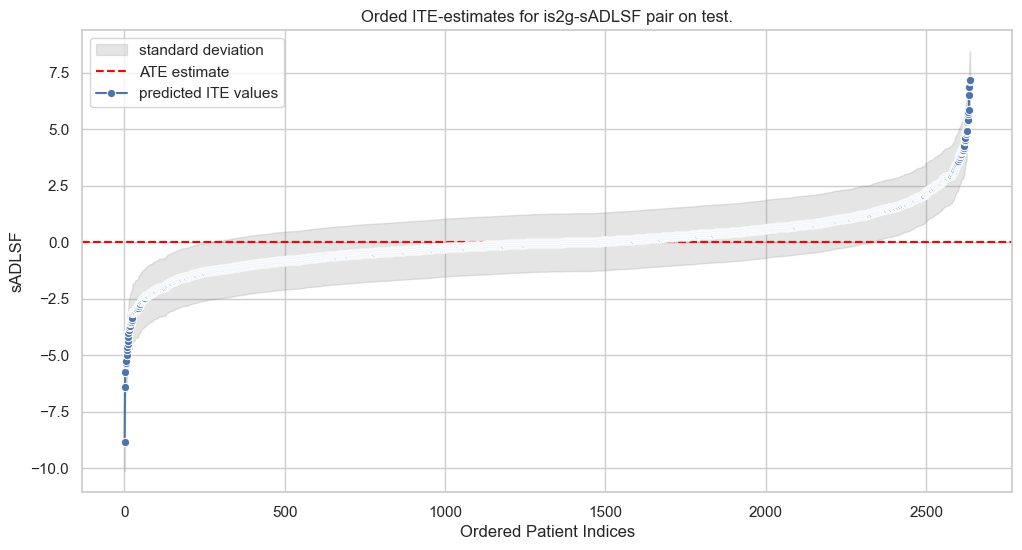

       ExtraTreesRegressor()
MAE_C               1.153544
MAE_T               1.056350
MSE_C               3.828466
MSE_T               3.820716
R2_C                0.814264
R2_T                0.738405
(-0.023141761468232613, 0.07454193848024462)
T-statistic: 1.0317870261891071
P-value: 0.302266553347384
Result is not significant
BaggingRegressor()
DF lenght after undersampling: 13181
{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
ATE: 0.02, 95% CI: [-1.90, 2.02]
ATE 0.011976900788077588


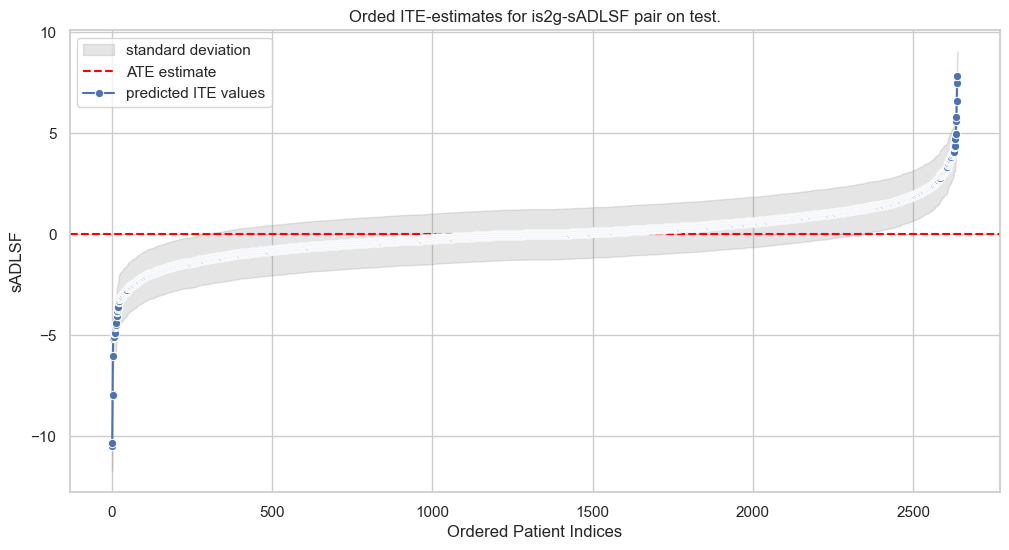

       BaggingRegressor()
MAE_C            1.111031
MAE_T            1.011550
MSE_C            3.594685
MSE_T            3.211027
R2_C             0.819970
R2_T             0.811924
(-0.035543265394930544, 0.05949706697108575)
T-statistic: 0.49421286939426107
P-value: 0.6211970324579972
Result is not significant


In [60]:
model_lst = [(RandomForestRegressor(),RandomForestRegressor()), (MLPRegressor(), MLPRegressor()), 
            (GradientBoostingRegressor(), GradientBoostingRegressor()), (DecisionTreeRegressor(), DecisionTreeRegressor()),
            (LinearRegression(), LinearRegression()), (Ridge(), Ridge()), (Lasso(), Lasso()),
            (AdaBoostRegressor(), AdaBoostRegressor()), (ExtraTreesRegressor(), ExtraTreesRegressor()), 
             (BaggingRegressor(), BaggingRegressor())]

for model1, model2 in model_lst:
    print(str(model1))
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c = run_model(n_bootstraps = 30, file = FILE, include_propensity = PROPENSITY, outcome=OUTCOME, intervention=TREATMENT, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1)
    #visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=target, intervention=intervention)
    visualise_ites(ites_test, machine = str(model1), intervention = TREATMENT, target = OUTCOME)
    print(metrics)
    confidence_interval(data=ites_test)
    significance(data=ites_test)

## Part 4. Adaptive Model

In this last part, we will predict the treatment effect using an adaptive model. This model was developed by us. As can be seen, there is a bit more coding involved, but the benefit is that it is easier to adapt this model to our preferences. 

The first step is to make sure that our model runs on the proper device. 

In [61]:
device = torch.device("cpu")

It is useful to have a small function that easily converts arrays to the correct ``torch``-objects: tensors.

In [62]:
to_tensor = lambda x: torch.tensor(np.array(x), dtype = torch.float32).to(device)

In [63]:
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"
df = pd.read_csv(FILE)

### Uplift Model

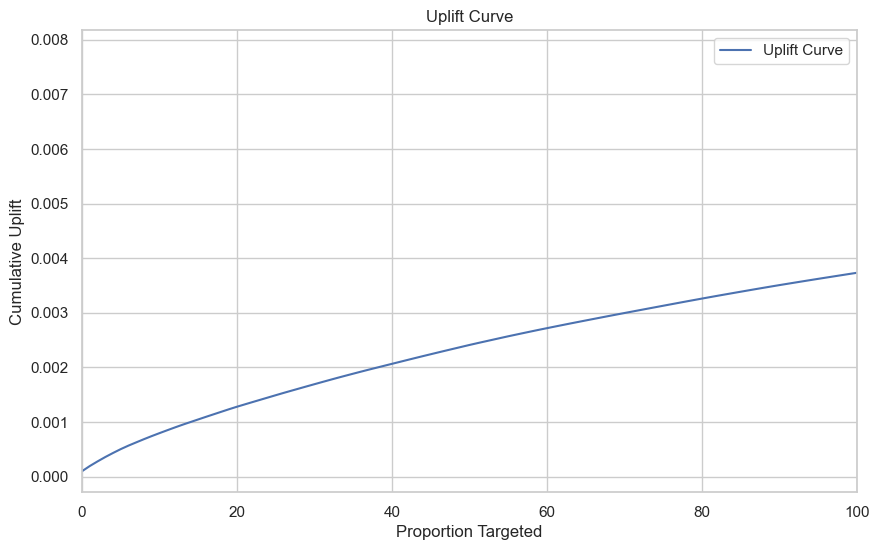

In [64]:
# Split into features and target
X = df.drop('OutcomeT1', axis=1)
y = df['OutcomeT1']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model on treatment group
model_treatment = LogisticRegression()
model_treatment.fit(X_train[X_train['treatment'] == 1].drop('treatment', axis=1), y_train[X_train['treatment'] == 1])

# Train model on control group
model_control = LogisticRegression()
model_control.fit(X_train[X_train['treatment'] == 0].drop('treatment', axis=1), y_train[X_train['treatment'] == 0])

# Predict probabilities
prob_treatment = model_treatment.predict_proba(X_test.drop('treatment', axis=1))[:, 1]
prob_control = model_control.predict_proba(X_test.drop('treatment', axis=1))[:, 1]

# Calculate uplift
uplift = prob_treatment - prob_control

# Sorting the individuals by predicted uplift
order = np.argsort(uplift)[::-1]
sorted_uplift = uplift[order]

# Calculating cumulative uplift
cumulative_uplift = np.cumsum(sorted_uplift) / len(y_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.xlim(0,100)
plt.plot(cumulative_uplift, label='Uplift Curve')
plt.xlabel('Proportion Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()
plt.show()

In [65]:
# apply min-max normalisation
#X = df.drop(columns = ['treatment', 'OutcomeT1']).columns
#df[X] = (df[X] - df[X].min()) / (df[X].max() - df[X].min())

In [66]:
X = df.drop(columns = ['treatment', 'OutcomeT1']).columns

normalizer = Normalizer(norm="l2")
normalizer.fit(df[X])

df[X] = normalizer.fit_transform(df[X])

with open(f'storage/normalizer_{TREATMENT}-{OUTCOME}.pkl', 'wb') as f:
    pickle.dump(normalizer, f)

### 4 a. Perform Undersampling Procedure

In [67]:
if UNDERSAMPLE:
    freq_treated = len(df[df['treatment']==1])
    control = df[df['treatment']==0].sample(freq_treated)
    treated = df[df['treatment']==1]
    df = pd.concat((control, treated))
    
print(f'DF lenght after undersampling: {len(df)}')

DF lenght after undersampling: 13181


Because the model is a neural-network based architecture, it is usually helpful to apply min-max normalisation which converts the column values to \[0,1\] ranges.

### 4.b Train-Test Splitting

In the cell below, we perform train-test split. Note that we also split the train and test data into two groups: a control group and a treated group. Even though we do not explicItely use for train, it will be useful for the (sub-)group evaluation later on.

In [68]:
# variable setting for treatment
t = 'treatment'
# select the relevant outcome
y = "OutcomeT1" 
# specify test size
test_size = 0.2

# Split groups into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = [y]), df[['treatment', y]], test_size=test_size, random_state=42)

### 4.c Propensity Score Computation

In [69]:
# predict the propensity score
if PROPENSITY:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]
    X_test["OutcomeT1"] = y_test["OutcomeT1"]
    X = X_train.drop(columns = ['treatment']).columns
    X = X_test.drop(columns = ['treatment']).columns
    ps_model = LogisticRegression(C=1e2, max_iter=10000).fit(X_train[X], y_train['treatment'])
    X_train['ps'] = ps_model.predict_proba(X_train[X])[:, 1]
    X_test['ps'] = ps_model.predict_proba(X_test[X])[:, 1]
    
    # ensure that treatment is last column
    X_train['treatment_new'] =  X_train['treatment']
    X_train = X_train.drop(columns = ['treatment'])
    X_train = X_train.rename(columns = {'treatment_new': 'treatment'})
    
    X_test['treatment_new'] =  X_test['treatment']
    X_test = X_test.drop(columns = ['treatment'])
    X_test = X_test.rename(columns = {'treatment_new': 'treatment'})
    
    #X_train = X_train.drop(columns = ["OutcomeT1"])
else:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]

In [70]:
X = df.drop(columns = ['OutcomeT1', 'treatment']).columns

#X_train = X_train.drop(columns = ["ps"])

# Estimate the average treatment effect (group level)
tau_est = doubly_robust(X_train, X=X, T='treatment', Y='OutcomeT1')
tau_est = torch.tensor(tau_est, dtype = torch.float32).to(device)
print(tau_est)

# drop columns
X_train = X_train.drop(columns = ["OutcomeT1"])

if PROPENSITY == True:
    X_test = X_test.drop(columns = ["OutcomeT1"])

Estimated outcome under control 4.945322356285194.
Estimated outcome under treatment 4.925589445156347.
tensor(-0.0357)


In [71]:
X_train

,ia4,ii1c,ii1d,ii1e,ii1f,ii1h,ii1p,ii1n,ii1o,ii1i,ii1w,if1d,cADL,sCPS,sPAIN,iA2,sAGE_cat,OutcomeT0,ps,treatment
1592,0.070263,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.023421,0.035132,0.011711,0.011711,0.995395,0.046842,0.217504,0.0
2391,0.044302,0.033227,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.022151,0.0,0.0,0.011076,0.022151,0.033227,0.022151,0.022151,0.996805,0.011076,0.402668,0.0
11849,0.026291,0.000000,0.000000,0.026291,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.013145,0.026291,0.013145,0.026291,0.985904,0.157745,0.126631,0.0
12830,0.044259,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.022130,0.000000,0.0,0.0,0.000000,0.022130,0.000000,0.022130,0.022130,0.995829,0.066389,0.293078,0.0
7303,0.013317,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.039950,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.026634,0.998758,0.000000,0.399138,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,0.024874,0.000000,0.000000,0.000000,0.0,0.037311,0.0,0.000000,0.000000,0.0,0.0,0.012437,0.000000,0.049748,0.037311,0.012437,0.994960,0.062185,0.222233,0.0
5191,0.049868,0.012467,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.012467,0.024934,0.024934,0.000000,0.024934,0.997354,0.024934,0.313241,1.0
5390,0.049740,0.000000,0.012435,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.012435,0.037305,0.000000,0.024870,0.994806,0.074610,0.219961,0.0
860,0.039784,0.009946,0.000000,0.000000,0.0,0.000000,0.0,0.019892,0.000000,0.0,0.0,0.000000,0.019892,0.039784,0.000000,0.019892,0.994594,0.079568,0.209015,0.0


We also want to make sure that the data stuctures are in the right format. For this, we use ``to_tensor``.

In [72]:
y_t = y_train[y_train['treatment']==1][y]
y_c = y_train[y_train['treatment']==0][y]

y_test_t = y_test[y_test['treatment']==1][y]
y_test_c = y_test[y_test['treatment']==0][y]

In [73]:
# convert output to tensors
x, y, y_t, y_c, x_test = to_tensor(X_train), to_tensor(y_train), to_tensor(y_t), to_tensor(y_c), to_tensor(X_test)

### 4.d Model Training

The next step is to train the actual model. The code below sets some preliminary configurations.

In [74]:
# Configurations
lr = 0.001
epochs = 1000
gamma = 2

model = TARnetICFR(x.shape[1], 0.01, hidden_dim = 32*4).to(device)

# Define the loss functions
head_loss = nn.L1Loss() #nn.MSELoss()#nn.L1Loss() #torch.nn.HuberLoss(reduction = 'mean', delta = 1) #nn.MSELoss() # nn.L1Loss() #nn.MSELoss() 

# initialise optimiser
optimizer = optim.Adam(model.parameters(), lr)

u = len(y_t)  / (len(y_t)  + len(y_c))

The code below is the training loop. On each loop, the model passes the data through the models, examines its performance and adjust the weights. Note that this model has four loss components:

1. Component 1 (``loss1``) is to loss on the treated segment of the data.
2. Component 2 (``loss2``) is to loss on the control segment of the data.
3. Component 2 (``loss_cf_3``) is to loss on the counterfactual control segment of the data.
4. Component 2 (``loss_cf_4``) is to loss on the counterfactual treated segment of the data.

In [75]:
# Define loss lists
loss1_lst, loss2_lst, loss3_lst = [], [], []

for epoch in range(epochs):
    # Forward pass
    output_t, output_c, _ = model(x)
    
    # Compute total loss and update the model's parameters
    loss1, loss2 = head_loss(torch.squeeze(output_t), y_t), head_loss(torch.squeeze(output_c), y_c)
    
    pred_c_cf = model.forward_treated(x[x[:,-1]==0])
    loss_cf_3 = (1 - u) * torch.mean((torch.squeeze(pred_c_cf) - (y_c + tau_est))**2)
                 
    pred_t_cf = model.forward_control(x[x[:,-1]==1])
    loss_cf_4 = u * torch.mean((torch.squeeze(pred_t_cf) - (y_t - tau_est))**2)
    
    # losses added
    loss = loss1 + (loss2) + loss_cf_3 + loss_cf_4 #+ (gamma * loss3)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10000 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}')
        
        # print intermediate results on test
        x_test_t = x_test[x_test[:,-1]==1] 
        x_test_c = x_test[x_test[:,-1]==0] 

        # # examine intermediate factual test performance
        y_t_pred = model.forward_treated(x_test_t).cpu().detach().numpy().reshape(len(x_test_t),)
        y_c_pred = model.forward_control(x_test_c).cpu().detach().numpy().reshape(len(x_test_c),)

        print(f"RMSE for factual treated {mean_squared_error(y_t_pred, y_test_t)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_t_pred, y_test_t)}") 
        print(f"RMSE for factual control {mean_squared_error(y_c_pred, y_test_c)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_c_pred, y_test_c)}") 

Epoch 100/1000 | Loss: 6.8280
RMSE for factual treated 3.531816377016243
MAE for factual treated 1.2106253849224906
RMSE for factual control 4.511038794010568
MAE for factual treated 1.3054059888846135
Epoch 200/1000 | Loss: 5.9050
RMSE for factual treated 3.1581622869884094
MAE for factual treated 1.0418534262411474
RMSE for factual control 3.9900753648493104
MAE for factual treated 1.151189008214571
Epoch 300/1000 | Loss: 5.7170
RMSE for factual treated 3.140632773351308
MAE for factual treated 1.0358830935845535
RMSE for factual control 3.904494274433512
MAE for factual treated 1.149696714062778
Epoch 400/1000 | Loss: 5.4982
RMSE for factual treated 2.76271750583857
MAE for factual treated 1.0076202571047221
RMSE for factual control 3.433184981565637
MAE for factual treated 1.1184314445334946
Epoch 500/1000 | Loss: 5.4941
RMSE for factual treated 2.6299750881326323
MAE for factual treated 1.023172408990238
RMSE for factual control 3.333725674579257
MAE for factual treated 1.14080912

### 4.e Model Evaluation
Having trained the model, we can no examine the performance on the test set. We first get the predictions for the treated and control groups. Then we visualise the predicted predicted vs. true values. 

             0     1        2
0     1.784294   2.0  treated
1    12.604946  15.0  treated
2     0.047413   1.0  treated
3    15.096556  16.0  treated
4     0.080004   0.0  treated
..         ...   ...      ...
708   0.258719   2.0  treated
709    1.24036   2.0  treated
710   0.053688   0.0  treated
711  13.085816  15.0  treated
712   0.532564   0.0  treated

[713 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
CHECK!
              0     1        2
0      1.784294   2.0  treated
1     12.604946  15.0  treated
2      0.047413   1.0  treated
3     15.096556  16.0  treated
4      0.080004   0.0  treated
...         ...   ...      ...
1919   10.67358  11.0  control
1920   10.95381  12.0  control
1921  12.990267  12.0  control
1922   -0.00675   3.0  control
1923   7.051028   6.0  control

[2637 rows x 3 columns]


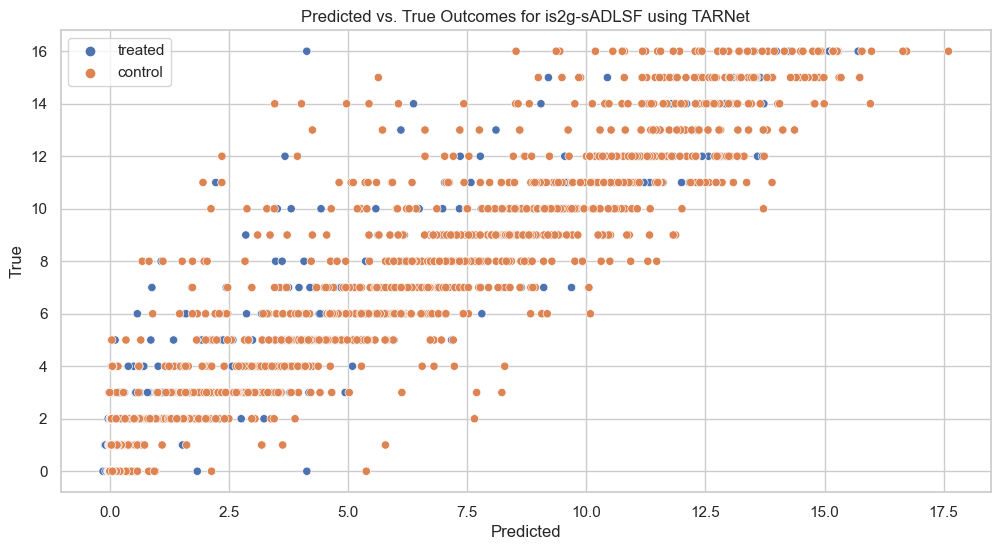

In [76]:
y_t_pred = model.forward_treated(x_test[x_test[:,-1]==1] ).cpu().detach().numpy()
y_c_pred = model.forward_control(x_test[x_test[:,-1]==0] ).cpu().detach().numpy()

machine = "TARNet"
visualise(np.squeeze(y_t_pred), np.squeeze(y_c_pred), y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Next, we want to estimate the model's predictions of the individual treatment effect. We plot this in an ordered fashion (from most beneficial to least beneficial). The blue dots depict patients. On the y-axis, we find the effect size as predicted by the model. 

ATE_est = 4.274562835693359 - 4.1942830085754395 = 0.08027978986501694.
ATE 0.08027976006269455


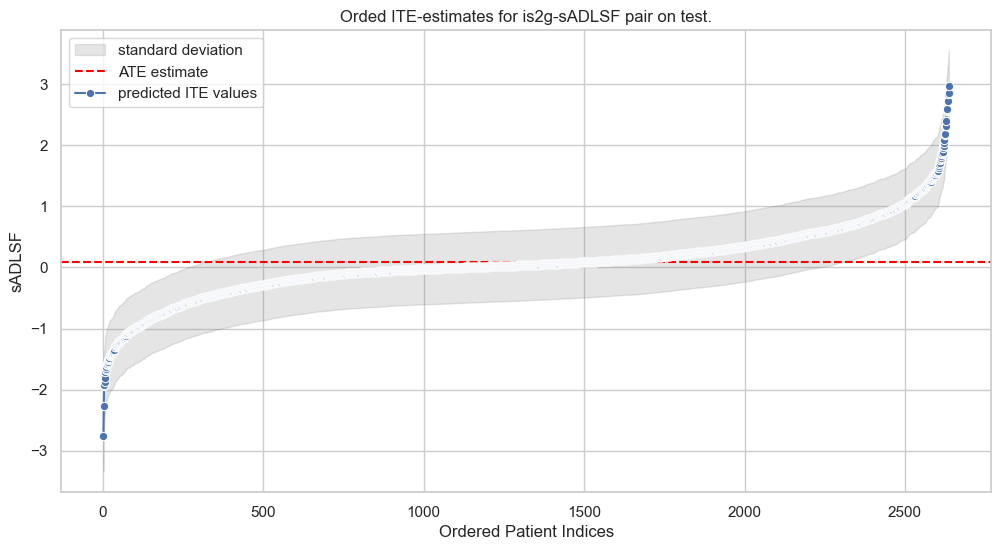

In [77]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()
y_t_predt1 = model.forward_treated(x_test_t).cpu().detach().numpy()
y_t_pred = np.concatenate((y_c_predt1, y_t_predt1))

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() #np.array(y_test_c).reshape(-1,1) #model.forward_control(x_test_c).cpu().detach().numpy()
y_t_predt0 = model.forward_control(x_test_t).cpu().detach().numpy()

y_c_pred = np.concatenate((y_c_predt0, y_t_predt0))

# compute the ites and sort
ites = y_t_pred - y_c_pred
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_t_pred - y_c_pred)

print(f"ATE_est = {np.mean(y_t_pred)} - {np.mean(y_c_pred)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE_est = 4.877687931060791 - 4.688982009887695 = 0.1887059360742569.
ATE 0.1887059211730957


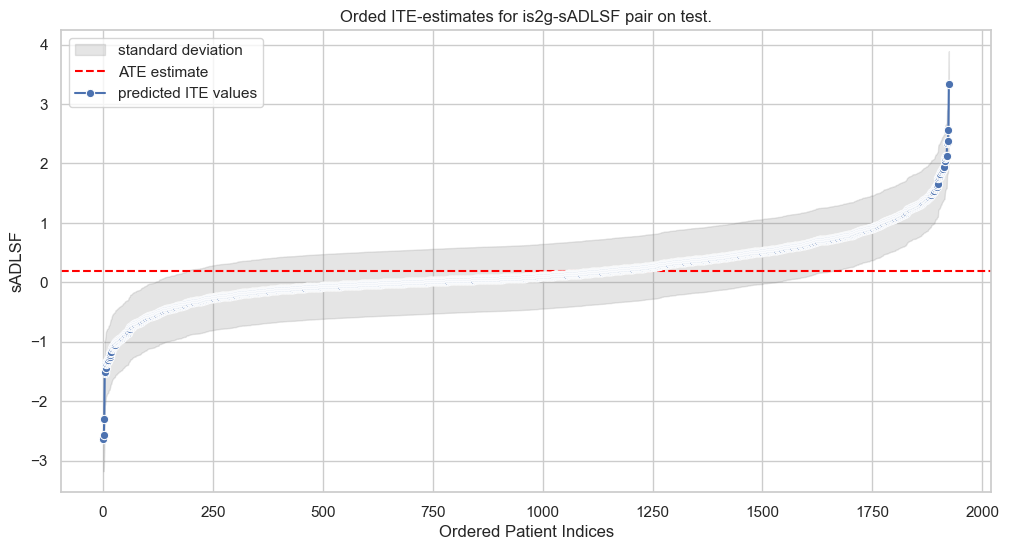

In [78]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() 

# compute the ites and sort
ites = y_c_predt1 - y_c_predt0
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_c_predt1 - y_c_predt0)

print(f"ATE_est = {np.mean(y_c_predt1)} - {np.mean(y_c_predt0)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

### 4.e Variable Importances

In [79]:
np.random.seed(42)

# Calculate the baseline performance
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Ensure no gradients are computed
    output_t, output_c, _ = model(x)
baseline_performance = mean_squared_error(output_t, y_t)
print(baseline_performance)

# Initialize a list to hold the feature importances
feature_importances = []
icodes = []
meanings = []
rank = []

collist = X_train.columns

# Calculate the importance for each feature
for i in range(x.shape[1]):  # Iterate over each feature
    # Save the original feature
    original_feature = x[:, i].clone()
    # Permute the feature
    permuted_feature = original_feature[torch.randperm(original_feature.size(0))]
    x[:, i] = permuted_feature
    
    # Calculate performance with the permuted data
    with torch.no_grad():
        output_t, output_c, _ = model(x)
        
    permuted_performance_t = mean_squared_error(output_t, y_t)
    permuted_performance_c = mean_squared_error(output_c, y_c)
    
    permuted_performance = permuted_performance_t + permuted_performance_t
    
    # Calculate the importance as the change in performance
    importance = baseline_performance - permuted_performance
    feature_importances.append(importance)
    
    # Restore the original feature
    x[:, i] = original_feature
    
# Rank the features by their importance
sorted_features = np.argsort(feature_importances)[::-1]  # Indices of features, sorted by importance

# Print the feature importances
print("Feature importances:")
for i, feature_index in enumerate(sorted_features):
    #print(f"Feature {feature_index}: Importance {feature_importances[feature_index]}")
    icode = collist[feature_index]
    icodes.append(icode.lower())
    
    try:
        item = encoding[icode.lower()]
        #print(item)
        meanings.append(item)
    except KeyError:
        #print(f'{icode} not found')
        meanings.append(f'{icode} not found')
    #print("==================================================")
    
rankings = pd.DataFrame(icodes, columns = ['icodes'])
rankings['meanings'] = meanings
rankings['importance_values'] = feature_importances

rankings = rankings.sort_values(by = 'importance_values')
rankings = rankings.reset_index().drop(columns = 'index')
rankings

3.050803
Feature importances:


,icodes,meanings,importance_values
0,treatment,treatment not found,-117.044754
1,ps,ps not found,-71.836510
2,ii1h,Parkinsons disease,-22.563951
3,outcomet0,OutcomeT0 not found,-7.038296
4,ii1d,Dementia other than Alzheimers disease,-6.864152
5,if1d,Loneliness: indicates feelings of loneliness,-6.252310
6,ii1c,Alzheimers disease,-6.174368
7,spain,sPAIN not found,-5.133130
8,ii1i,Quadriplegia,-4.833899
9,scps,sCPS Cognitive Performance Scale 0-6 range-Mor...,-4.140463


## Save Model

In [80]:
model

TARnetICFR(
  (phi): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ELU(alpha=1.0)
  )
  (y0_hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (y1_hidden): Sequential(
    (0): Linear(in_features=128,

In [81]:
model = model
location = 'storage'

In [82]:
# save model
with open(f'storage/model_{TREATMENT}-{OUTCOME}.pkl', 'wb') as f:
    pickle.dump(model, f)

In [83]:
# load model
with open(f'storage/model_{TREATMENT}-{OUTCOME}.pkl', 'rb') as b:
    loaded_model = pickle.load(b)

In [84]:
loaded_model

TARnetICFR(
  (phi): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ELU(alpha=1.0)
  )
  (y0_hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (y1_hidden): Sequential(
    (0): Linear(in_features=128,